### Цель: 
- исследование поведения клиентов оператора сотовой связи,  
- определение наиболее прибыльного и перспективного тарифного плана, 
- проверка гипотез о различии средней выручки:
        1) пользователей тарифов «Ультра» и «Смарт»
        2) пользователей из Москвы и пользователей из других регионов

### Шаг 1. Открываю файлы с данными и изучаю общую информацию

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

In [55]:
calls = pd.read_csv('./datasets/calls.csv')
internet  = pd.read_csv('./datasets/internet.csv')
sms = pd.read_csv('./datasets/messages.csv')
users = pd.read_csv('./datasets/users.csv')
tariffs = pd.read_csv('./datasets/tariffs.csv')

In [56]:
datasets = [calls, internet, sms, users, tariffs]

Пропуски в столбце `churn_date` датафрейма `users`. Более 90% клиентов из выборки ещё продолжают пользоваться указанными тарифами. Данные стобца `churn_date` не участвуют в дальнейших расчетах.

В нескольких столбцах со значениями даты данные имеют формат `object`.

In [57]:
for i in datasets:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.D

In [58]:
for i in datasets:
    print(i.head())

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   

In [59]:
for i in datasets:
    print(i.sample())

             id   call_date  duration  user_id
24224  1061_304  2018-11-15      5.12     1061
        Unnamed: 0       id  mb_used session_date  user_id
105882      105882  1358_76   215.02   2018-05-21     1358
             id message_date  user_id
30682  1134_400   2018-01-21     1134
     user_id  age churn_date       city  first_name last_name    reg_date  \
284     1284   62        NaN  Волгоград  Евфросинья  Петухова  2018-03-16   

    tariff  
284  smart  
   messages_included  mb_per_month_included  minutes_included  \
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
1             1950         150                1               1       ultra  


In [60]:
for i in datasets:
    print(i.tail())

              id   call_date  duration  user_id
202602  1499_215  2018-12-26      0.76     1499
202603  1499_216  2018-10-18     18.83     1499
202604  1499_217  2018-11-10     10.81     1499
202605  1499_218  2018-10-06      4.27     1499
202606  1499_219  2018-12-14     19.62     1499
        Unnamed: 0        id  mb_used session_date  user_id
149391      149391  1499_152   318.90   2018-10-03     1499
149392      149392  1499_153   490.13   2018-12-14     1499
149393      149393  1499_154     0.00   2018-10-27     1499
149394      149394  1499_155  1246.32   2018-11-26     1499
149395      149395  1499_156   544.37   2018-10-26     1499
              id message_date  user_id
123031  1499_179   2018-12-12     1499
123032  1499_180   2018-09-28     1499
123033  1499_181   2018-09-27     1499
123034  1499_182   2018-11-15     1499
123035  1499_183   2018-11-16     1499
     user_id  age  churn_date         city first_name last_name    reg_date  \
495     1495   65         NaN      Ирку

### Шаг 2. Подготовка данныx

Перевожу в формат `datetime` значения в стобцах с датами.

In [61]:
for file in datasets:
    for column in file.columns:
        if '_date' in column:
            file[column] = pd.to_datetime(file[column], format='%Y.%m.%d')

Добавляю информацию о клиентах к информации о звонках - объединяю датафремы `users` и `calls` на основе `user_id`

In [62]:
users_calls = calls.merge(users, on='user_id', how='left')

Около 20% звонков имеют длительность 0 минут. Основная гипотеза, что это ошибка измерения сверхмалых значений. Поэтому заменяю на 1 минуту.

In [63]:
users_calls.query('duration == 0.00')['duration'].count()

39613

In [64]:
users_calls.query('duration != 0.00')['duration'].count()

162994

In [65]:
users_calls['duration'] = users_calls['duration'].replace(0, 1)

В соответствии с правилами оператора сотовой связи о поминутной тарификации, округляю вверх значения `duration` 

In [66]:
users_calls['duration'] = np.ceil(users_calls['duration'])

Меняю в `duration` тип данных на `int`, потому что значения измеряются в целых минутах 

In [67]:
users_calls['duration'] = users_calls['duration'].astype('int')

Добавляю информацию о клиентах к информации об интернет-сессиях - объединяю датафремы `users` и `internet` на основе `user_id`

In [68]:
users_internet = internet.merge(users, on='user_id', how='left')

В соответствии с правилами оператора сотовой связи о помегабайтной тарификации, округляю вверх значения `mb_used` 

In [69]:
users_internet['mb_used'] = np.ceil(users_internet['mb_used'])

Меняю в `mb_used` тип данных на `int`, потому что значения измеряются в целых мегабайтах

In [70]:
users_internet['mb_used'] = users_internet['mb_used'].astype('int')

Добавляю информацию о клиентах к информации о сообщениях - объединяю датафремы `users` и `sms` на основе `user_id`

In [71]:
users_sms = sms.merge(users, on='user_id', how='left')

В каждом датафрейме с определенным типом связи создаю новый столбец `month` со значениями месяца

In [72]:
users_calls['month'] = pd.DatetimeIndex(users_calls['call_date']).month
users_sms['month'] = pd.DatetimeIndex(users_sms['message_date']).month
users_internet['month'] = pd.DatetimeIndex(users_internet['session_date']).month

#### 1) Количество сделанных звонков по месяцам для каждого клиента

Группирую датафрейм с информацией о звонках и клиентах по id клиента и месяцу

In [73]:
calls_m = users_calls.groupby(['user_id', 'month'])['id'].count()
calls_m = calls_m.reset_index()
calls_m = calls_m.rename(columns={'id': 'count'})
calls_m.head()

,user_id,month,count
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58


#### 2) Количество израсходованных минут разговора по месяцам для каждого клиента

Проверяю, что у каждого `user_id` только один город

In [74]:
for i in users['user_id']:
    L = []
    if len(users.query('user_id == @i')['city']) > 1:
        L.append(i)
print(L)

[]


Группирую датафрейм с информацией о звонках и клиентах по id клиента и месяцу. Данные о городе и тарифе будут полезны в дальнейшей работе

In [75]:
month_m = users_calls.groupby(['user_id', 'month', 'city', 'tariff'])[['duration']].sum()

In [76]:
month_m = month_m.reset_index()

In [77]:
month_m.head()

,user_id,month,city,tariff,duration
0,1000,5,Краснодар,ultra,164
1,1000,6,Краснодар,ultra,187
2,1000,7,Краснодар,ultra,346
3,1000,8,Краснодар,ultra,418
4,1000,9,Краснодар,ultra,478


#### 3) Количество отправленных сообщений по месяцам для каждого клиента

Группирую датафрейм с информацией о сообщениях и клиентах по id клиента и месяцу. Данные о городе и тарифе будут полезны в дальнейшей работе

In [78]:
sms_m = users_sms.groupby(['user_id', 'month', 'city', 'tariff'])[['id']].count()
sms_m = sms_m.reset_index()

In [79]:
sms_m = sms_m.rename(columns={'id': 'sms'})

In [80]:
sms_m.head()

,user_id,month,city,tariff,sms
0,1000,5,Краснодар,ultra,22
1,1000,6,Краснодар,ultra,60
2,1000,7,Краснодар,ultra,75
3,1000,8,Краснодар,ultra,81
4,1000,9,Краснодар,ultra,57


#### 4) Oбъем израсходованного интернет-трафика по месяцам для каждого клиента

Группирую датафрейм с информацией об интернет-сессиях и клиентах по id клиента и месяцу. Данные о городе и тарифе будут полезны в дальнейшей работе

In [81]:
mb_m = users_internet.groupby(['user_id', 'month', 'city', 'tariff'])[['mb_used']].sum()

In [82]:
mb_m = mb_m.reset_index()

In [83]:
mb_m.head()

,user_id,month,city,tariff,mb_used
0,1000,5,Краснодар,ultra,2256
1,1000,6,Краснодар,ultra,23257
2,1000,7,Краснодар,ultra,14016
3,1000,8,Краснодар,ultra,14070
4,1000,9,Краснодар,ultra,14581


#### 5) Помесячная выручка с каждого клиента

Предполагаю, что не каждый клиент постоянно пользуется всеми тремя видами связи. Поэтому после группировки датафреймы `sms_m`, `month_m` и `mb_m` могут иметь разный размер. 

In [84]:
sms_m['user_id'].count()

2717

In [85]:
month_m['user_id'].count()

3174

In [86]:
mb_m['user_id'].count()

3203

Создаю датафрейм `revenue` - к самому большому датафрейму об интернет-сессия добавляю второй по размеру о длительности звонков

In [87]:
revenue = mb_m.merge(month_m, on=['user_id', 'month'], how='left', suffixes=('', '_x'))

Проверяю пропуски

In [88]:
revenue.isnull().sum()

user_id      0
month        0
city         0
tariff       0
mb_used      0
city_x      40
tariff_x    40
duration    40
dtype: int64

Пропуски означают, что данные клиенты не совершали звонков

In [89]:
revenue.query('duration != duration').head(10)

,user_id,month,city,tariff,mb_used,city_x,tariff_x,duration
570,1091,5,Набережные Челны,ultra,10714,NaN,NaN,NaN
571,1091,6,Набережные Челны,ultra,10245,NaN,NaN,NaN
572,1091,7,Набережные Челны,ultra,16460,NaN,NaN,NaN
573,1091,8,Набережные Челны,ultra,12644,NaN,NaN,NaN
574,1091,9,Набережные Челны,ultra,16611,NaN,NaN,NaN
575,1091,10,Набережные Челны,ultra,15659,NaN,NaN,NaN
576,1091,11,Набережные Челны,ultra,11876,NaN,NaN,NaN
577,1091,12,Набережные Челны,ultra,13292,NaN,NaN,NaN
671,1106,4,Калуга,ultra,2925,NaN,NaN,NaN
672,1106,5,Калуга,ultra,16591,NaN,NaN,NaN


In [90]:
month_m.query('user_id == 1091')

,user_id,month,city,tariff,duration


In [91]:
month_m.query('user_id == 1106')

,user_id,month,city,tariff,duration


Заполняю пропуски `duration` нулевым значением

In [92]:
revenue['duration'] = revenue['duration'].fillna(0)

К датафрейму `revenue` добавляю третий по размеру о количестве сообщений

In [93]:
revenue = revenue.merge(sms_m, on=['user_id', 'month'], how='left', suffixes=('', '_y'))

Проверяю пропуски

In [94]:
revenue.isnull().sum()

user_id       0
month         0
city          0
tariff        0
mb_used       0
city_x       40
tariff_x     40
duration      0
city_y      497
tariff_y    497
sms         497
dtype: int64

Пропуски означают, что данные клиенты не отправляли сообщений

In [95]:
revenue.query('sms != sms').head(10)

,user_id,month,city,tariff,mb_used,city_x,tariff_x,duration,city_y,tariff_y,sms
8,1001,11,Москва,smart,18452,Москва,smart,444.0,NaN,NaN,NaN
9,1001,12,Москва,smart,14053,Москва,smart,430.0,NaN,NaN,NaN
42,1006,2,Ульяновск,smart,1395,Ульяновск,smart,42.0,NaN,NaN,NaN
43,1006,3,Ульяновск,smart,17309,Ульяновск,smart,296.0,NaN,NaN,NaN
44,1006,4,Ульяновск,smart,13954,Ульяновск,smart,365.0,NaN,NaN,NaN
45,1006,5,Ульяновск,smart,12984,Ульяновск,smart,381.0,NaN,NaN,NaN
46,1006,6,Ульяновск,smart,12388,Ульяновск,smart,483.0,NaN,NaN,NaN
47,1006,7,Ульяновск,smart,20000,Ульяновск,smart,327.0,NaN,NaN,NaN
48,1006,8,Ульяновск,smart,19327,Ульяновск,smart,285.0,NaN,NaN,NaN
49,1006,9,Ульяновск,smart,15543,Ульяновск,smart,367.0,NaN,NaN,NaN


In [96]:
sms_m.query('user_id == 1001')

,user_id,month,city,tariff,sms


In [97]:
sms_m.query('user_id == 1006')

,user_id,month,city,tariff,sms


Заполняю пропуски `sms` нулевым значением

In [98]:
revenue['sms'] = revenue['sms'].fillna(0)

Сохраняю в `revenue` только нужные для дальнейшей работы столбцы

In [99]:
revenue = revenue.loc[:, ['user_id', 'month', 'city', 'duration', 'sms', 'mb_used', 'tariff']]

Переименовываю столбец `tarrif` в `tariff_name`

In [100]:
revenue = revenue.rename(columns={'tariff': 'tariff_name'})

Добавляю в `revenue` инфомацию об условиях тарифов - объединяю датафреймы по значению `tariff_name`

In [101]:
revenue = revenue.merge(tariffs, on='tariff_name', how='left')

Функция для расчета выручки с каждого клиента в случае превышения лимитов тарифа

In [102]:
def revenue_month(row):
    """
    row - строка датафрейма revenue
    
    По каждому из трех типов связи проверяем превышен ли лимит тарифа.
    Если лимит превышен, то в соответствии с условиями тарифа, вычисляем размер платы.
    Функция возвращает общую дополнительную плату по всем трем видам связи.
    """
    min_rub = 0
    sms_rub = 0
    mb_rub = 0
    minutes = row['duration']
    sms = row['sms']
    mb = row['mb_used']
    sms_inc = row['messages_included']
    mb_inc = row['mb_per_month_included']
    min_inc = row['minutes_included']
    rub_per_minute = row['rub_per_minute']
    rub_per_message = row['rub_per_message']
    rub_per_gb = row['rub_per_gb']
    if minutes > min_inc:
        min_rub = (minutes - min_inc) * rub_per_minute
    if sms > sms_inc:
        sms_rub = (sms - sms_inc) * rub_per_message
    if mb > mb_inc:
        mb_rub = ((mb - mb_inc) / 1024) * rub_per_gb
    return min_rub + sms_rub + mb_rub

Создаю новый столбец `revenue` с дополнительной платой в случае превышения лимитов тарифа. Округляю значения до двух знаков после запятой, что соответствует копейкам

In [103]:
revenue.head()

,user_id,month,city,duration,sms,mb_used,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,Краснодар,164.0,22.0,2256,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,Краснодар,187.0,60.0,23257,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,Краснодар,346.0,75.0,14016,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,Краснодар,418.0,81.0,14070,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,Краснодар,478.0,57.0,14581,ultra,1000,30720,3000,1950,150,1,1


In [104]:
revenue['revenue'] = revenue.apply(revenue_month, axis=1)

In [105]:
revenue['revenue'] = revenue['revenue'].round(2)

Создаю новый столбец `revenue_total` с суммой абонентской платы по тарифу и платы в случае превышения лимитов

In [106]:
revenue['revenue_total'] = revenue['revenue'] + revenue['rub_monthly_fee']

Сохраняю в `revenue` только нужные для дальнейшей работы столбцы

In [107]:
revenue = revenue.loc[:, ['user_id', 'city', 'month', 'duration', 'sms', 'mb_used', 'tariff_name', 'revenue', 'revenue_total']]

Проверяю результат

In [108]:
revenue.head(10)

,user_id,city,month,duration,sms,mb_used,tariff_name,revenue,revenue_total
0,1000,Краснодар,5,164.0,22.0,2256,ultra,0.00,1950.00
1,1000,Краснодар,6,187.0,60.0,23257,ultra,0.00,1950.00
2,1000,Краснодар,7,346.0,75.0,14016,ultra,0.00,1950.00
3,1000,Краснодар,8,418.0,81.0,14070,ultra,0.00,1950.00
4,1000,Краснодар,9,478.0,57.0,14581,ultra,0.00,1950.00
5,1000,Краснодар,10,363.0,73.0,14717,ultra,0.00,1950.00
6,1000,Краснодар,11,344.0,58.0,14768,ultra,0.00,1950.00
7,1000,Краснодар,12,341.0,70.0,9827,ultra,0.00,1950.00
8,1001,Москва,11,444.0,0.0,18452,smart,603.91,1153.91
9,1001,Москва,12,430.0,0.0,14053,smart,0.00,550.00


#### Выбросы

Функция для построения графиков boxplot и гистограммы, вывода значений среднего, квартилей(25%, 50% и 75%), верхнего уса, а также доли выбросов для выбранного столбца `revenue`. Выбросы определяются, как превышение верхнего уса

In [109]:
def outlier(column):
    Q1 = revenue[column].quantile(0.25)
    Q3 = revenue[column].quantile(0.75)
    IQR = Q3 - Q1
    print('Среднее:', revenue[column].mean())
    print('Первый квартиль(25%):', Q1)
    print('Медиана:', revenue[column].median())
    print('Третий квартиль(75%):', Q3)
    print('Верхний ус:', (Q3 + (IQR * 1.5)))
    revenue.hist(column, bins=30)
    plt.show()
    revenue.boxplot(column)
    plt.show()
    print('Доля выбросов: {:.1%}' \
          .format((len(revenue[revenue[column] > (Q3 + (IQR * 1.5))]) / len(revenue))))    

Исследую выбросы в столбце `duration`

Среднее: 464.43053387449265
Первый квартиль(25%): 293.0
Медиана: 456.0
Третий квартиль(75%): 606.0
Верхний ус: 1075.5


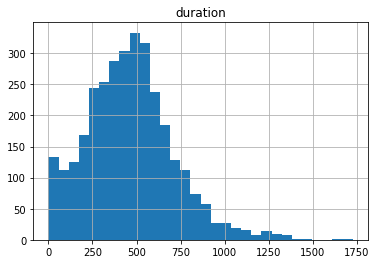

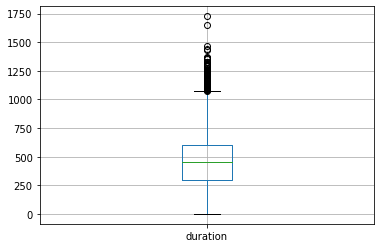

Доля выбросов: 2.0%


In [110]:
outlier('duration')

Выбросы, превышающие верхний ус, составляю 2% от всей выборки. Это достоверные значения, поэтому я не буду их удалять.

In [111]:
revenue.query('duration > 1075').head()

,user_id,city,month,duration,sms,mb_used,tariff_name,revenue,revenue_total
148,1021,Краснодар,7,1230.0,103.0,20038,ultra,0.00,1950.00
150,1021,Краснодар,9,1141.0,113.0,18321,ultra,0.00,1950.00
159,1024,Санкт-Петербург,11,1176.0,0.0,43146,ultra,1820.21,3770.21
185,1028,Тверь,12,1214.0,171.0,15805,ultra,0.00,1950.00
383,1060,Калуга,12,1273.0,52.0,43973,ultra,1941.36,3891.36


Исследую выбросы в столбце `sms`

Среднее: 38.32594442709959
Первый квартиль(25%): 9.0
Медиана: 30.0
Третий квартиль(75%): 57.0
Верхний ус: 129.0


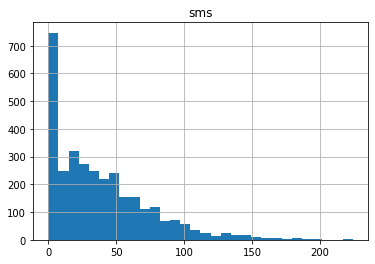

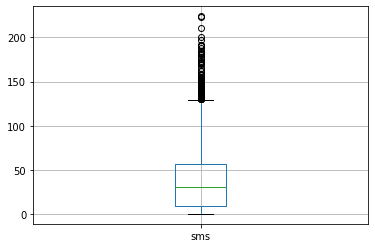

Доля выбросов: 2.8%


In [112]:
outlier('sms')

Выбросы, превышающие верхний ус, составляю 2.8% от всей выборки. Это достоверные значения, поэтому я не буду их удалять.

In [113]:
revenue.query('sms > 129').head()

,user_id,city,month,duration,sms,mb_used,tariff_name,revenue,revenue_total
23,1004,Новокузнецк,6,177.0,134.0,17619,ultra,0.0,1950.0
24,1004,Новокузнецк,7,137.0,181.0,22243,ultra,0.0,1950.0
25,1004,Новокузнецк,8,138.0,151.0,28607,ultra,0.0,1950.0
26,1004,Новокузнецк,9,125.0,146.0,15125,ultra,0.0,1950.0
27,1004,Новокузнецк,10,153.0,165.0,18494,ultra,0.0,1950.0


Исследую выбросы в столбце `mb_used`

Среднее: 17286.74960974087
Первый квартиль(25%): 12543.0
Медиана: 16985.0
Третий квартиль(75%): 21455.5
Верхний ус: 34824.25


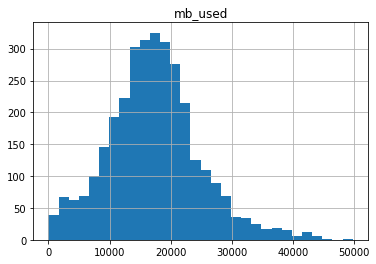

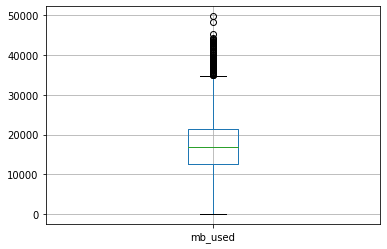

Доля выбросов: 2.4%


In [114]:
outlier('mb_used')

Выбросы, превышающие верхний ус, составляю около 2.4% от всей выборки. Это достоверные значения, поэтому я не буду их удалять.

In [115]:
revenue.query('mb_used > 34825').head()

,user_id,city,month,duration,sms,mb_used,tariff_name,revenue,revenue_total
159,1024,Санкт-Петербург,11,1176.0,0.0,43146,ultra,1820.21,3770.21
160,1024,Санкт-Петербург,12,977.0,0.0,35985,ultra,771.24,2721.24
260,1042,Хабаровск,12,755.0,75.0,37219,smart,5109.34,5659.34
311,1050,Тюмень,7,218.0,52.0,35205,ultra,656.98,2606.98
383,1060,Калуга,12,1273.0,52.0,43973,ultra,1941.36,3891.36


### Шаг 3. Анализ данных

Функция для вывода значения среднего, дисперсии, стандартного отклонения и построения графиков boxplot и гистрограммы для значений определенного столбца по определенному тарифу

In [116]:
def dist(tariff, column):
    """
    tariff - тарифный план клиента
    column - столбец со значениями для которого производятся вычисления
    """
    print('Среднее:', revenue[revenue['tariff_name'] == tariff][column].mean())
    print('Дисперсия:', revenue[revenue['tariff_name'] == tariff][column].var())
    print('Стандартное отклонение:', revenue[revenue['tariff_name'] == tariff][column].std())
    revenue[revenue['tariff_name'] == tariff].hist(column, bins=30)
    plt.show()
    revenue[revenue['tariff_name'] == tariff].boxplot(column)
    plt.show()

#### 1) Сколько минут разговора требуется  пользователям каждого тарифа в месяц? 

Пользователи тарифа `«Смарт»`

Распределение приближенно к нормальному. Среднее значение составляет 429 минуту и близко к медиане. Стандартное отклонение 194.

Среднее: 429.62118491921007
Дисперсия: 37927.14426586058
Стандартное отклонение: 194.74892622517996


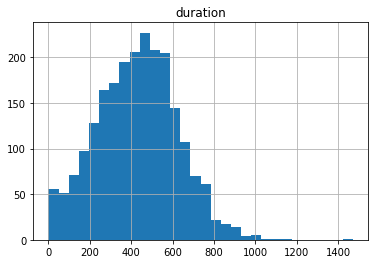

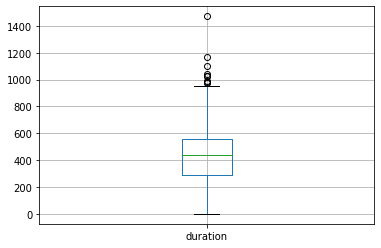

In [117]:
dist('smart', 'duration')

Пользователи тарифа `«Ультра»`

Среднее значение составляет 543 минуты и близко к медиане. Стандартное отклонение 325.

Среднее: 543.974358974359
Дисперсия: 106122.44800716071
Стандартное отклонение: 325.7644056786449


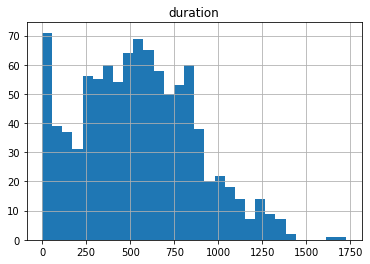

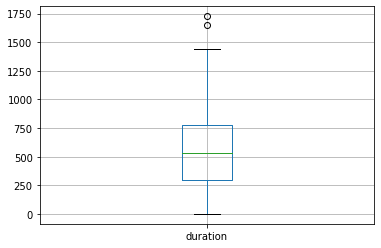

In [118]:
dist('ultra', 'duration')

#### 2)  Сколько сообщений требуется пользователям каждого тарифа в месяц?

Пользователи тарифа `«Смарт»`

Выделяется большое количество значений менее 5 сообщений. Среднее значение составляет 33 сообщения и близко к медиане. Стандартное отклонение 28.

Среднее: 33.398563734290846
Дисперсия: 796.6996297278673
Стандартное отклонение: 28.225868095204216


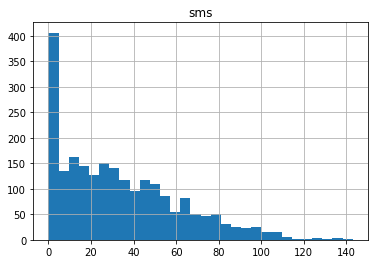

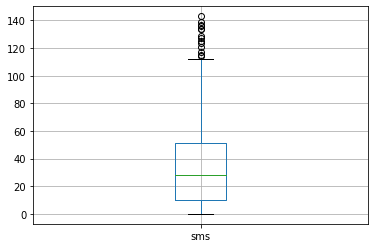

In [119]:
dist('smart', 'sms')

Пользователи тарифа `«Ультра»`

Выделяется большое количество значений менее 10 сообщений. Среднее значение составляет 48 сообщений и близко к медиане. Стандартное отклонение 46.

Сейчас люди редко пользуются SMS. Пропуски в общей таблице я заполнил 0. Это 497 значений, поэтому они выделяются на гистограммах.

Среднее: 49.585641025641024
Дисперсия: 2301.9246396040603
Стандартное отклонение: 47.97837679209313


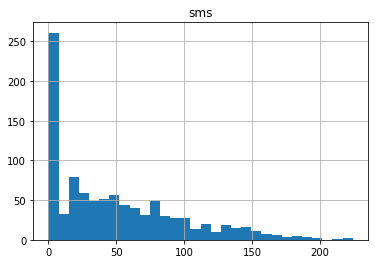

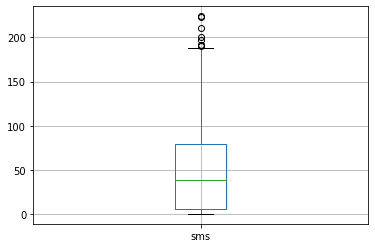

In [120]:
dist('ultra', 'sms')

####  3) Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Пользователи тарифа `«Смарт»`

Распределение приближенно к нормальному. Среднее значение составляет 16236 мегабайт и близко к медиане. Стандартное отклонение 5868.

Среднее: 16236.47262118492
Дисперсия: 34443100.68133363
Стандартное отклонение: 5868.824471845587


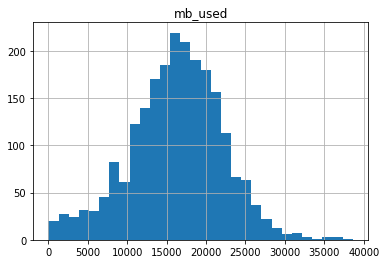

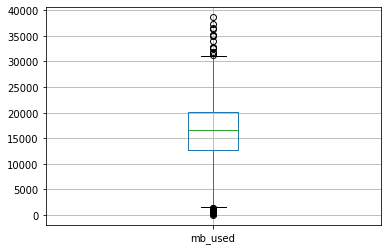

In [121]:
dist('smart', 'mb_used')

Пользователи тарифа `«Ультра»`

Распределение приближенно к нормальному. Среднее значение составляет 19686 мегабайт и несколько меньше медианы. Стандартное отклонение 9952.

Среднее: 19686.76717948718
Дисперсия: 99043439.60795656
Стандартное отклонение: 9952.057054094725


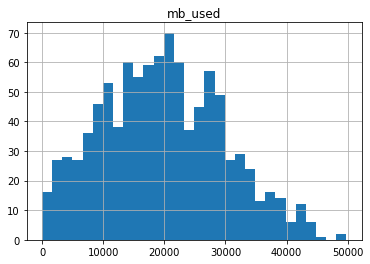

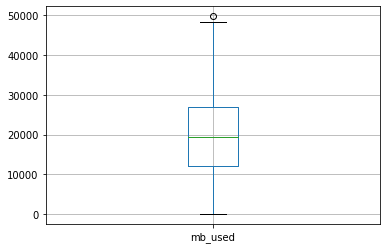

In [122]:
dist('ultra', 'mb_used')

### Шаг 4. Проверка гипотез

#### 1) Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза формулируется как равенство. Альтернативная гипотеза - как различие.

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются<br>
Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Создаю датафреймы с данными по каждому тарифу

In [123]:
smart = revenue[revenue['tariff_name'] == "smart"]['revenue_total']

In [124]:
ultra = revenue[revenue['tariff_name'] == "ultra"]['revenue_total']

Согласно центральной предельной теореме, если в выборке достаточно наблюдений, выборочное распределение выборочного среднего из любой генеральной совокупности распределено нормально вокруг среднего этой генеральной совокупности. Эксперты сообщают, что мы имеем достаточную выборку, поэтому можно использовать t-test.

Стоит задача проверить гипотезу о равенстве средних двух генеральных совокупностей - пользователи тарифа «Ультра» и пользователи тарифа «Смарт». Поэтому применяю метод `scipy.stats.ttest_ind()`

In [125]:
alpha = 0.05 #критический уровень статистической значимости
results = st.ttest_ind(smart, ultra)
print('p-значение:', results.pvalue) #уровень значимости
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 4.1289837387351846e-179
Отвергаем нулевую гипотезу


Нулевая гипотеза была отвергнута. Есть основания полагать, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [126]:
smart.mean()

1250.6395152603232

In [127]:
ultra.mean()

2061.6636410256397

#### 2) Гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза формулируется как равенство. Альтернативная гипотеза - как различие.

Нулевая гипотеза: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов<br>
Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Создаю датафреймы с данными пользователей из Москвы и пользователей из других регионов

In [128]:
moscow = revenue[revenue['city'] == "Москва"]['revenue_total']

In [129]:
others = revenue[revenue['city'] != "Москва"]['revenue_total']

Согласно центральной предельной теореме, если в выборке достаточно наблюдений, выборочное распределение выборочного среднего из любой генеральной совокупности распределено нормально вокруг среднего этой генеральной совокупности. Эксперты сообщают, что мы имеем достаточную выборку, поэтому можно использовать t-test.

Стоит задача проверить гипотезу о равенстве средних двух генеральных совокупностей - пользователи из Москвы и пользователи из других регионов. Поэтому применяю метод `scipy.stats.ttest_ind()`

In [130]:
alpha = 0.05 #критический уровень статистической значимости
results = st.ttest_ind(moscow, others)
print('p-значение:', results.pvalue)  #уровень значимости
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.49587928330631337
Не отвергаем нулевую гипотезу


Нулевая гипотеза не была отвергнута. Есть основания полагать, что средняя выручка пользователей из Москвы существенно не отличается от выручки пользователей из других регионов.

In [131]:
moscow.mean()

1517.0377414075292

In [132]:
others.mean()

1492.9154436728404

### Шаг 5. Общий вывод

#### Какой тариф приносит больше денег?

В абсолютных значения выручки по всей выборке больше денег приносит тариф `«Смарт»` - 2786424 рублей против 2010122 рублей

In [133]:
tariffs = revenue.groupby('tariff_name')['revenue_total'].sum()
tariffs = tariffs.reset_index()
tariffs

,tariff_name,revenue_total
0,smart,2786424.84
1,ultra,2010122.05


Средняя выручка на одного пользователя тарифа `«Смарт»` составляет 7938 рублей, тарифа `«Ультра»` - 13490 рублей

In [134]:
tariff_users = users.groupby('tariff')['user_id'].count()
tariff_users = tariff_users.reset_index()
tariff_users

,tariff,user_id
0,smart,351
1,ultra,149


In [135]:
tariffs['revenue_total'][0] / tariff_users['user_id'][0]

7938.532307692307

In [136]:
tariffs['revenue_total'][1] / tariff_users['user_id'][1]

13490.75201342281

#### Какой тариф наиболее перспективный?

Хотя средняя общая выручка пользователей тарифа Смарт почти в два раза меньше, этот тариф привлекает большее количество пользователей и их средняя добавочная выручка на 15% выше, чем у пользователей тарифа Ультра. Поэтому можно предположить, что тариф Смарт более перспективен для развития и привлечения новых пользователей.

In [137]:
tariff_users

,tariff,user_id
0,smart,351
1,ultra,149


25% пользователей тарифа Смарт не выходят за пределы лимитов

In [138]:
len(revenue.query('tariff_name == "smart" and revenue == 0')) \
/ len(revenue.query('tariff_name == "smart"'))

0.24820466786355475

Средняя плата при превышении лимитов по тарифу Смарт составляет 931 рубль

In [139]:
revenue.query('tariff_name == "smart" and revenue != 0')['revenue'].mean()

931.955128358209

86% пользователей тарифа Ультра не выходят за пределы лимитов

In [140]:
len(revenue.query('tariff_name == "ultra" and revenue == 0')) \
/ len(revenue.query('tariff_name == "ultra"'))

0.8625641025641025

Средняя плата при превышении лимитов по тарифу Ультра составляет 812 рублей

In [141]:
revenue.query('tariff_name == "ultra" and revenue != 0')['revenue'].mean()

812.4779850746272

### Общий вывод:
#### Предобработка:
- В ходе предобработки обнаружены нулевые значения длительности звонка(около 20% выборки). Они предположительно возникли из-за ошибки измерения сверхмалых значений, поэтому были округлены вверх до одной минуты. 
- Значения о времени разговора и объёме трафика были округлены вверх.

#### Исследование:
- Проведено исследование поведения клиентов оператора сотовой связи. Определён наиболее прибыльный и перспективный тарифный план.
- Абсолютная выручка тарифного плана Смарт составляет 2786424 рублей, что на 38% больше, чем у тарифа Ультра. 86% пользователей тарифа Ультра не выходят за пределы лимитов. Для тарифа Смарт таких около 25%. 
- Средние значения использования каждого типа связи не имеют существенного различия в зависимости от тарифа. Из этого можно сделать вывод, что пользователи тарифа Ультра не в полной мере тратят лимиты, установленные тарифом. Из-за высокой абонентской платы они приносят больше выручки, чем пользователи тарифа Смарт, даже с учетом платы за превышение лимитов последними.
- При условии репрезентативности выборки, количество пользователей тарифа Смарт в два раза больше. Их средняя добавочная выручка на 15% выше. Что позволяет сделать вывод о переспективности тарифа Смарт для развития и привлечения новых клиентов.
- Проведена проверка гипотезы о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. По результатам можно сделать вывод, что средняя выручка по тарифам скорее различается.
- Проведена проверка гипотезы о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. По результатам можно сделать вывод, что средняя выручка в Москве и остальных регионах скорее не различается.